`morphen`, a collection of python tools for astronomical image analysis. <br>
By Geferson Lucatelli

# Multi Sersic Image Fitting

Objectives:
1. Characterize the radio emission from radio maps.
2. Disentangle the radio subcomponents on these structures, such as compact components and diffuse emission
3. Break down the total flux contribution coming from the diffuse emission in relation to compact emission.

Methods: Using multi-resolution radio images, we perform a multiscale Sersic decomposition of the radio emission. 

Specific Objectives:
1. Find relevant regions of radio emission from radio maps; and characterize then.
2. Estimate the sizes (convolved and deconvolved) of the radio emission
3. From the disentangled contribution from diffuse emission (assuming that it is synchrotron), use it as a proxy of SFR. 

Basically, this notebook contains:

    1. Plotting capabilities
    2. Signal processing / Image analysis (non-parametric)
    3. A fast and semi-automated image fitting decomposition implementation using the Sersic Law. 
    4. Others

Multiple libraries, functions, etc, are placed in the library file `libs/libs.py`. The module `morphen.py` helps to deal with different kinds of tasks. You can run it on a notebook or as a `CLI`. 



#### ISSUES: 
#### ***Using version 1.1.0 (`pip install lmfit==1.1.0`) is a MUST!!!.***
Please, do not use LMFIT version above 1.1.0. 

Actual reasons: Unknown

Possible reason: the communication of LMFIT (and SciPy) with JaX capabilities for LMFIT > 1.1.0 is not working as intended. We require a deeper investigation of what is causing this.

What is the effect? Minimisation gets stuck at boundaries!

Index:

1. [Introduction/Imports](#imports) <br>
2. [Data Manipulation](#data_manipulation) <br>
    2.1 [Preparing Images](#preparing_images) <br>
3. [Source Extraction](#source_extraction) <br>
4. [Multi-Sersic Fitting](#multi_sersic_fitting) <br>

<a id='imports'></a>

Currently, all python functions are located in the file `libs/libs.py`. 

In [1]:
import sys
import morphen as mp
# sys.path.append('libs/')
import libs as mlibs
import numpy as np
# from libs import *


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
   Radio Morphen              |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

## 1 - Reading Imaging Data

A set of example images can be found in this link: 

https://filedn.com/lNSVniBJI40jEXAJtSnTjPQ/astrodata/LIRGI_sample/data_examples/data_examples.tar.xz
<br>
With this, you can experiment with the general usage of `morphen`. 

In [2]:
root_path_vla = 'data_examples/vla_only/VV705_C/' #only JVLA images.
root_path_eM = 'data_examples/emerlin_only/VV705_C/' #only e-MERLIN images.
root_path_comb = 'data_examples/combined/VV705_C/' #combined (e-MERLIN + JVLA) images.
prefix_images = 'MFS_images/north/*MFS-image.cutout_north.fits' #The north component of VV705

In [3]:
imagelist_vla = mlibs.glob.glob(root_path_vla+prefix_images)
imagelist_comb = mlibs.glob.glob(root_path_comb+prefix_images)
imagelist_eM = mlibs.glob.glob(root_path_eM+prefix_images)

In [4]:
#this function is helpfull to sort the image list according to the restoring 
# beam size (from smaller beams to larger beams). 
imagelist_vla,residuallist_vla = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_vla,return_df = False)
imagelist_eM,residuallist_eM = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_eM,return_df = False)
imagelist_comb,residuallist_comb = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_comb,return_df = False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 67.94it/s]


0 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
1 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
2 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
3 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 103.02it/s]


0 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..-0.5-MFS-image.cutout_north.fits
1 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
2 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
3 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
4 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 106.73it/s]

0 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-1.0-MFS-image.cutout_north.fits
1 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.6-MFS-image.cutout_north.fits
2 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.4-MFS-image.cutout_north.fits
3 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.2-MFS-image.cutout_north.fits
4 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
5 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
6 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits


In [5]:
imagelist_comb

array(['data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-1.0-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.6-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.4-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.2-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits',


In [6]:
residuallist_vla

array(['data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-residual.cutout_north.fits',
       'data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-residual.cutout_north.fits',
       'data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-residual.cutout_north.fits',
       'data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-residual.cutout_north.fits'],
      dtype=object)

In [7]:
imagelist_eM,residuallist_eM = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_eM,return_df = False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 101.10it/s]

0 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..-0.5-MFS-image.cutout_north.fits
1 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
2 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
3 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
4 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits


In [8]:
residuallist_eM

array(['data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..-0.5-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-residual.cutout_north.fits'],
      dtype=object)

# 2 - Source Extraction

Before we head to the Sersic fitting, we should inspect the structure of the radio emission. 
For that, we can perform a simple source extraction from the image and compute basic prior information, which includes:

1. Finding relevant regions of emission, applying deblending where required. We then have the locations `(x0,y0)` of these regions.
2. Then, we compute first order sizes and effective intensities of these regions, for example $R_{50}$, $I_{50}$ and $R_p$.
3. It is also relevant to quantify the axis ratio and position angles of these structures. 

We use these informations to construct a physically constrained Sersic model. 

To do this, we use the class `source_extraction`, which allow us to find relevant regions of emission and determine our prior information. 
Only after that, one should proceed to the Sersic fitting. 

Let's load our data again, if required.

In [9]:
# lets select another image from our list of images. 
idx = -1
input_data=mp.read_data(filename=imagelist_eM[idx],
                        residualname=residuallist_eM[idx])

Image File: clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits
Residual File: clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-residual.cutout_north.fits


In [10]:
image_data = input_data.image_data_2D
residual_data = input_data.residual_data_2D

  >> Center -->  [512 510   0   0]


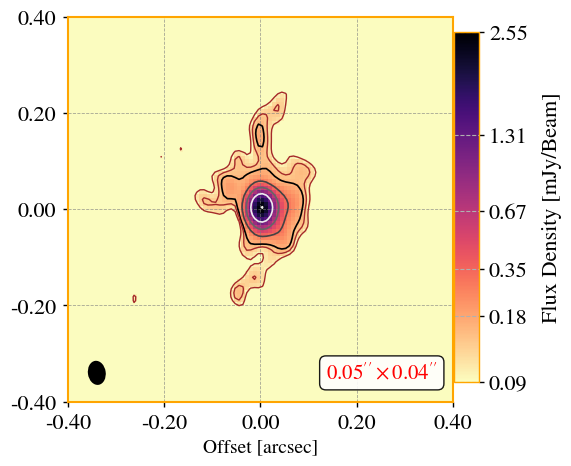

In [11]:
ax=mlibs.eimshow(input_data.filename,add_beam=True,crop=True,box_size=50,
        vmin_factor=3.0,vmax_factor=0.99, #level factor (max from peak, and min from std)
        neg_levels=np.asarray([-3]), # negative contours to draw -- which negative std level?
        CM='magma_r',
       )

Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


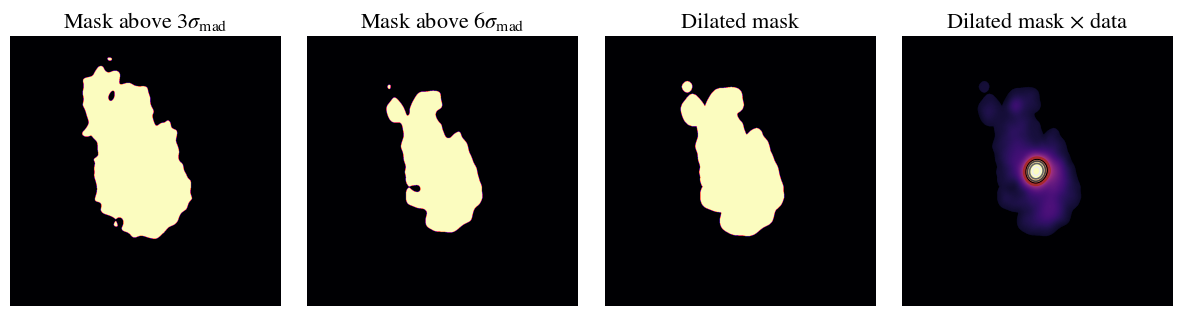

Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


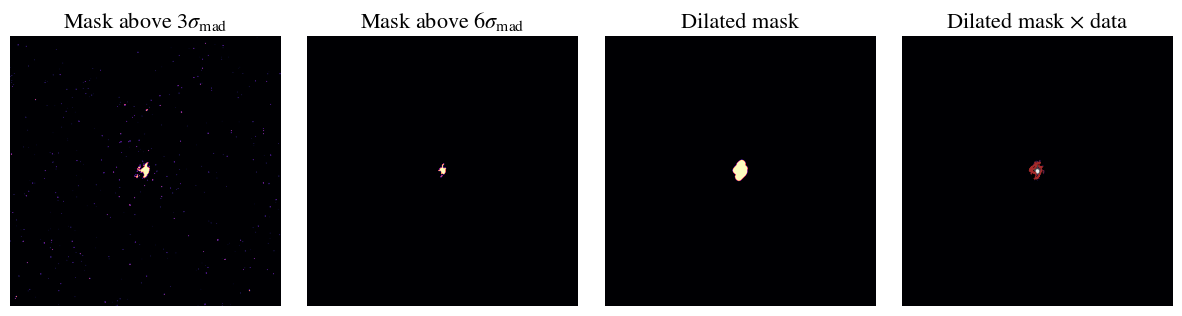

In [12]:
std = mlibs.mad_std(mlibs.ctn(imagelist_vla[2]))
_, mask = mlibs.mask_dilation(mlibs.ctn(imagelist_vla[2]), PLOT=True,dilation_type='disk',
                        sigma=6, iterations=2, dilation_size=None)
_, mask_self = mlibs.mask_dilation(mlibs.ctn(input_data.filename), PLOT=True,dilation_type='disk',
                        sigma=6, iterations=2, dilation_size=None)


In [13]:
def get_ell_size_factor(psf_current, psf_large=50, ell_large=2.0, psf_small=4, ell_small=7):
    """
    Rough linear relation between the restoring beam size (psf) with the scale factor of the ellipse to 
    be drawn on the detection map.
    """
    return ell_large + (ell_small - ell_large) * ((psf_current - psf_large) / (psf_small - psf_large))

### 3.1 Testing the Source-Extraction
Lets now run a source extraction in our image to extract relevant information. Parameters that are critical for the source detection are the `SEP` arguments for the source extraction `bwf`, `bhf`, `fwf` and `fhf`:
```
- bwf : int
    Box width fraction in terms of the beam size
    for the background estimation.
- bhf : int
    Box height fraction in terms of the beam size
    for the background estimation.
- fwf : int
    Filter width fraction in terms of the beam size
    for the background estimation.
- fhf : int
    Filter height fraction in terms of the beam size
    for the background estimation.
```
Currently, we are also implementing a Photutils algorithm (within PetroFit) for source detection, but more testing is required. We also plan to include AstroDendro and PyBDSF capabilities for this task.

WARNING: This is implementation is in an early stage, so it is not completely automated. It is required that the user interacts with it in order to check if the source detection is feasible. That usually involves, from the default parameters below, run the source extraction in the image and check if it went well. If not (e.g. false detections, artefacts, etc), play around with the parameters until okay. 
Improvements are being made so that this can be escalated to multiple images. 



In [14]:
bwf, bhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 10, 10 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.1
deblend_cont = 1e-2
deblend_nthresh = 5
sigma = 6
# ell_size_factor = 2.5
ell_size_factor = 1.0*get_ell_size_factor(psf_current = mlibs.get_beam_size_px(input_data.filename)[0])

In [15]:
# mp.source_extraction??


To check if the source detection is good, you may pass the argument `dry_run=True` which will only display the regions detected, without performing any calculations. 

So, lets run a `dry_run` source detection. This will only show the detected sources, without returning any prior properties (faster).

This is useful in case you do not know for sure the noise structure of the image. Suppose that the number of structures detected are many (false detections, due to poor SNR). That will take some time to compute their properties. 

5.393645922749118
Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.


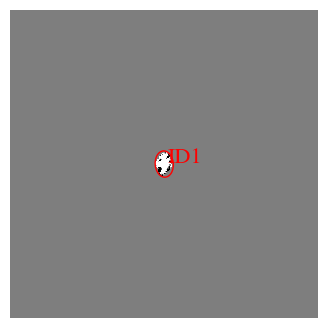

In [16]:

SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=1.0,
                          apply_mask=True,sigma_mask=6,
                          show_petro_plots=True,
                          dry_run=True)
# plt.imshow(input_data.image_data_2D)

In [17]:
SE.objects['xc'],SE.objects['yc']

(array([512]), array([511]))

### 3.2 Decomposition of the Radio Emission
After the source detection is performed, there is an additional step to be investigated. By 'source', we mean a spatial region responsible for emitting radio emission: 
1. This region/source can be simple, mono-component such as a blob or a compact structure.
2. Or this region/source can be composite/complicated, having a compact structure surrounded by other structures, such as diffuse emission. So, this source contains multiple radio components.
  
In principle, the detection algorithm used here will not distinguish those components, and they are identified as just a source. So, we have to investigate the following question: ***Is a single model component enough to model each detected individual source?***

In the example above, is one model component (for structure `ID1`) enough to model the source emission? Let's look at the data again:

  >> Center -->  [512 510   0   0]


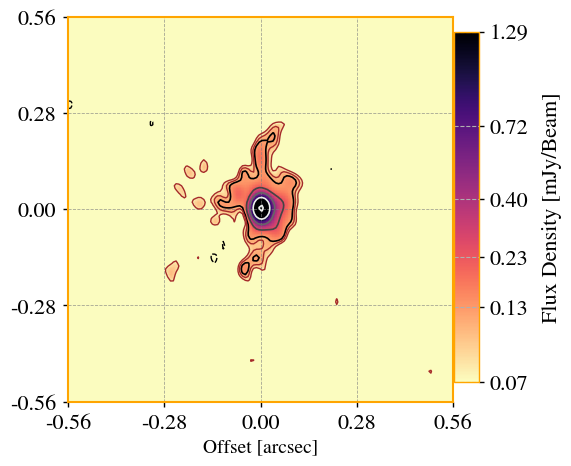

In [18]:
ax=mlibs.eimshow(input_data.filename,crop=True,box_size=70)

### ** The answer is: probably not! ** 

We see that `ID1` is a composite source, containing a compact structure surrounded by some asymmetric and more diffuse emission. In this case, when modelling this source with the Sersic decomposition, we have to tell the algorithm that `ID1` is composite and requires more than one model component. 

What we can do is to specify to which source ID we may add an extra model component. 
The default is to attribute to each `ID` a model component `COMP`, for example, `ID_1` > `COMP_1`, `ID_2` > `COMP_2`, etc. 
But in our case, since `ID1` is composite, we require an extra model component to `ID_1`, i.e. `COMP_2`. This will result in `ID_1 -> (COMP_1, COMP_2)`

The `source_extraction` class, the argument used for this is `ids_to_add`, which is a list of IDs where we want to add extra model components. In our case, to add another model component to `ID1`, we use `ids_to_add = [1]`. So, our source `ID1` will be decomposed into `COMP_1` and `COMP_2`. 

***Note that at the current stage of `morphen`, this is a manual step. In a future version this will be fully automated.***



If you are happy with the source detection, have decided how many components (`COMP_`s) do you need, and have attributed the components to corresponding source `ID`s, you may proceed. Remember to set `dry_run = False`.

5.393645922749118
Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
object 0: flux = 0.047991 +/- 5.326161


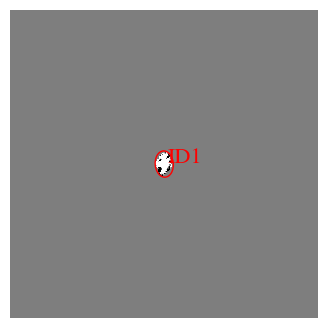

1


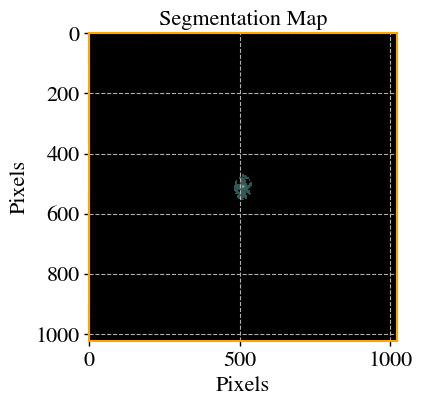

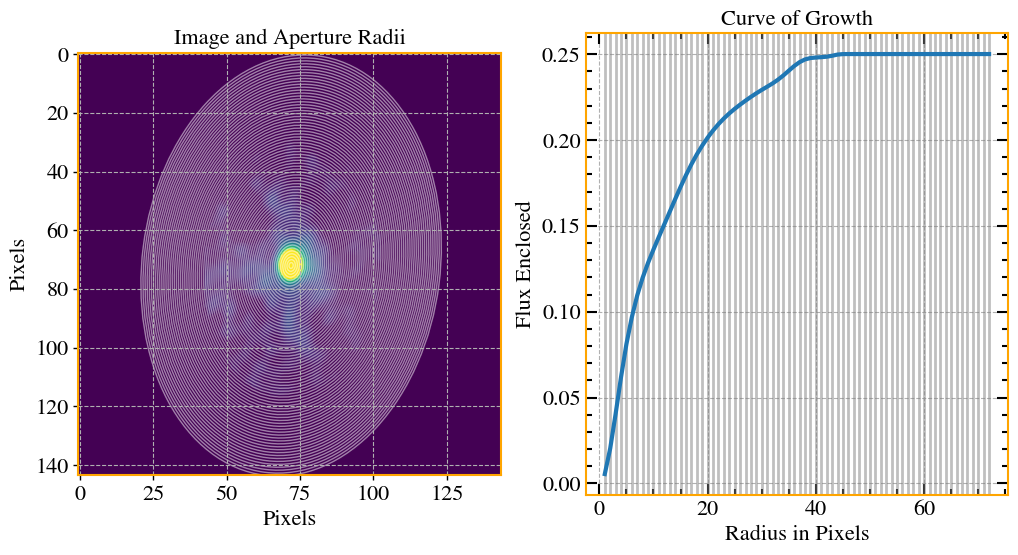

/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-10-11 02:41:37	WARN	componentlist::close	componentlist closed


# of components to be fitted = 1
# of model components to be fitted = 2


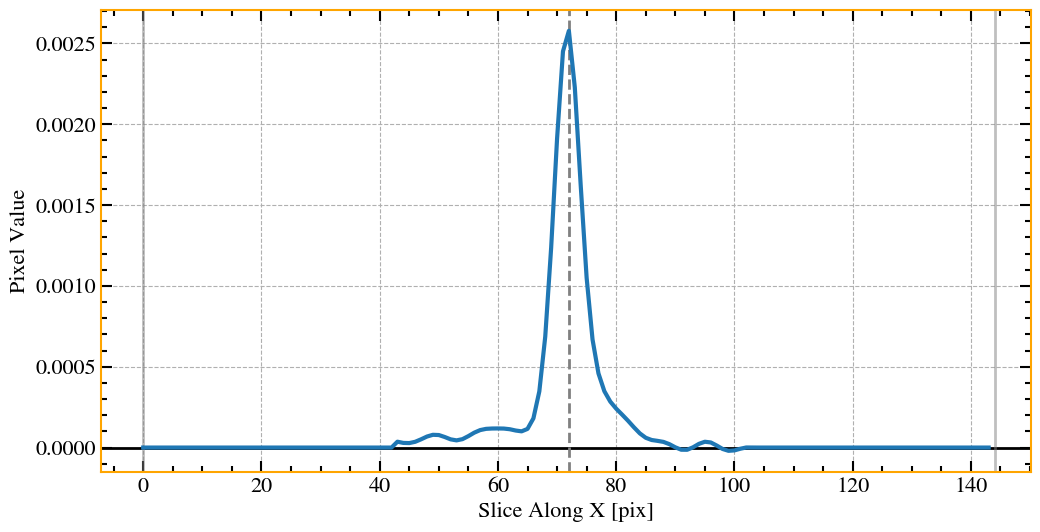

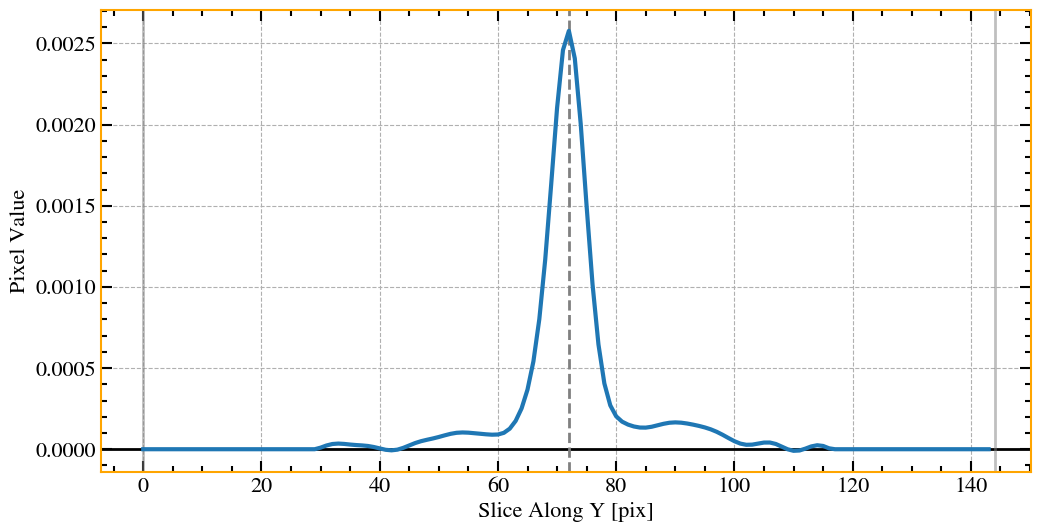

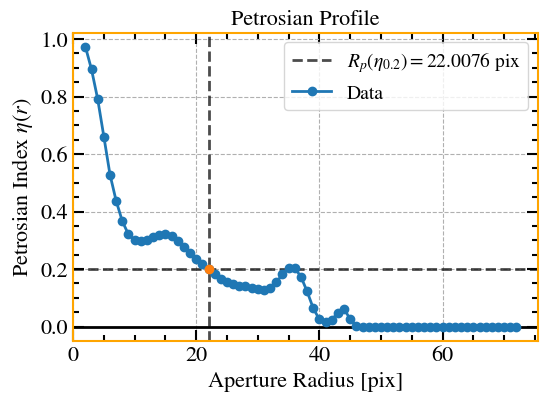

In [80]:
SE = mp.source_extraction(input_data, ids_to_add=[1],
                          ell_size_factor = ell_size_factor, sigma=sigma,
                          bwf=bwf, bhf=bhf, fwf=fwf, fhf=fhf,
                          clean_param=clean_param, 
                          deblend_cont=deblend_cont, 
                          deblend_nthresh=deblend_nthresh,
                          apply_mask=True,sigma_mask=10,
                          show_petro_plots=True,
                          dry_run=False)

When using `mp.source_extraction` (`SE`) with `dry_run = False`, it returns a dictionary with basic photometric information of each source (`SE.sources_photometries`). 
If in the previous step no extra component was added (i.e. `ids_to_add = []`), this dictionary will have the same number of model components as the number of detection sources. 

When another extra component is added, components that are added to a source ID will contain similar information as the parent ID. For example, in our case originally we had `ID_1 -> COMP_1`, then `COMP_2` will be a copy of `COMP_1` with the following modifications:
<!-- - the positions of `COMP_1`, `(x0,y0)` are copied onto `COMP_2`. -->
- the starting constraint of the effective radii of `COMP_2` is 3 times of that of `COMP_1`.
- the starting constraint of the effective intensity of `COMP_2` is 0.1 times of that of `COMP_1`.

Now, in our example, we have `ID_1 -> (COMP_1, COMP_2)`.


We can check the dictionary containing such photometric properties:

In [81]:
SE.sources_photometries

{'c1_PA': -82.72347761576026,
 'c1_q': 0.7051105127612137,
 'c1_area': 2938.0,
 'c1_Re': 30.580949063231785,
 'c1_x0c': 510.95272878324647,
 'c1_y0c': 512.1364166494816,
 'c1_label': 1,
 'c1_R50': 8.712142428485699,
 'c1_R20': 3.4570914182836567,
 'c1_R80': 20.102820564112825,
 'c1_C1': 0.7645461321544884,
 'c1_Snu': 0.24987159695911645,
 'c1_Rp': 22.00760152030406,
 'c1_Rpidx': 44,
 'c1_rlast': 72,
 'c1_I50': 0.00017761935643128318,
 'ncomps': 2,
 'c2_PA': -82.72347761576026,
 'c2_q': 0.7051105127612137,
 'c2_area': 2938.0,
 'c2_Re': 30.580949063231785,
 'c2_x0c': 510.95272878324647,
 'c2_y0c': 512.1364166494816,
 'c2_label': 1,
 'c2_R50': 26.136427285457096,
 'c2_R20': 3.4570914182836567,
 'c2_R80': 20.102820564112825,
 'c2_C1': 0.7645461321544884,
 'c2_Snu': 0.24987159695911645,
 'c2_Rp': 22.00760152030406,
 'c2_Rpidx': 44,
 'c2_rlast': 72,
 'c2_I50': 1.7761935643128318e-05}

More information can be found in the function responsible to generate a new model component from a parent one. 

In [82]:
mlibs.add_extra_component??

Signature: mlibs.add_extra_component(petro_properties, copy_from_id)
Source:   
def add_extra_component(petro_properties, copy_from_id):
    """
    Create another component from a dictionary (petro_properties) having
    photometric properties for N detected components in an image.

    Params
    ------
    petro_properties: dict
        Contain parameters of a number o N components obtained
        by a petrosian analysis of all detected sources.
        Example (these are actually the keys() from the dictionary):
        ['c1_PA', 'c1_q', 'c1_area', 'c1_Re',
        'c1_x0c', 'c1_y0c', 'c1_label', 'c1_R50',
        'c1_Snu', 'c1_Rp', 'c1_Rpidx', 'c1_rlast',
        'c1_I50']
    copy_from: int
        From which component copy parameters from.
        This is useful, for example, the source has two components detected,
        1 compact and the other a structure that can not be modelled by a single
        sersic function. Then, we need one function to model the compact structure,


#### A more complicated example, to show the feasibility of this method, is shown at the end of this notebook.

# Sersic Multi-Fit
Now, we are ready to proceed for to the fitting part. 

We can use the source extraction object `SE` to feed it into the multi-sersic fitting. 

Relevant arguments:
```
    fix_n : list (same shape as the number of components)
        List of booleans to fix the Sersic index.
        Default is None, will attibute True to all elements. 
    fix_value_n : list (same shape as the number of components)
        List of values to fix the Sersic index.
        Default is None, will attribute 0.5 to all elements.
    dr_fix : list (same shape as the number of components)
        List of values to fix radially (dr) the positions x0,y0. This will be the max boundary for each direction x and y.
        Default is None, will attribute 10 to all elements.

```
By default, the code fixes all Sersic indeces to `n=0.5` for all model components. It also fixes all components to its detected positions `(x0,y0)` during the source extraction step, but gives an interval of +/-10 px during the optimisation. 

You can modify these options by passing the arguments `dr_fix = [3,50]`, meaning that `COMP_1` is very spatially constrained, and can vary only +/- 3 pixels, while `COMP_2` is spatially constrained to a larger bound, the algorithm will search in the boundary of +/- 50 pixels during optimisation.

Another important observation is that, since we want to decompose the radio structure in terms of compact and diffuse emission, we must specify which model components corresponds to compact structures and diffuse structures. 

In our case, `COMP_1` (always the brightest part of the source, an assumption that holds for compact structures) is our compact model, and `COMP_2` will be our diffuse model. Do not worry about the diffuse labels, just focus on the compact labels. We pass this information via the argument `comp_ids`. The algorithm will determine automatically the labels for diffuse structures (in our case, will be `2`). If your model has a single model component (e.g. in the previous step, you have used `ids_to_add = []`), diffuse structures will be considered to be the residual. 

A comprehensive example using 5 model components is provided at the end of this notebook.


#######################
['2'] ['1' '2']
Fitting clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits
rms res =  0.9969088591188711
rms data =  17.54974547763469 ; rms res =  17.495496741935366 ; ratio =  0.9969088591188711
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


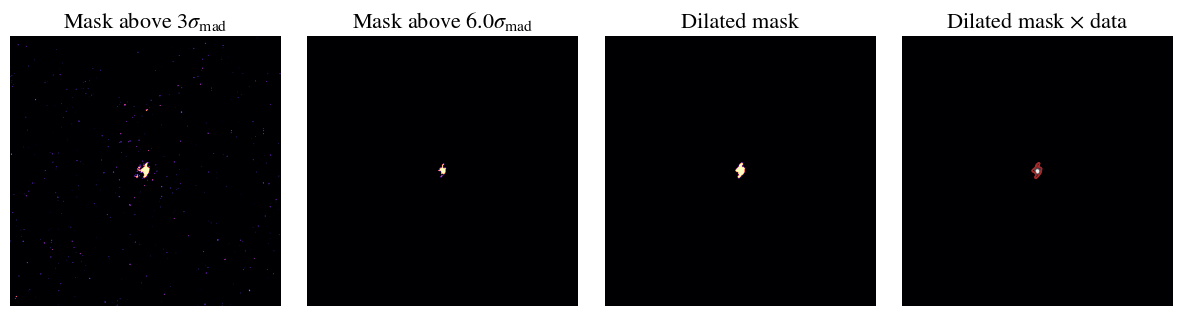

PSF BEAM SIZE is >=>  5
PSF SIZE is >=>  1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-10-11 02:42:40	WARN	componentlist::close	componentlist closed
2023-10-11 03:42:40 - DEBUG - ---------------------------------------
2023-10-11 03:42:40 - DEBUG -  <<< PERFORMING CONVOLUTION WITH GPU >>> 
2023-10-11 03:42:40 - DEBUG - ---------------------------------------
2023-10-11 03:42:40 - DEBUG -  ==> Using clean shuffled background for optmization... 


Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
{'f1_x0': {'value': 510.95272878324647, 'min': 505.95272878324647, 'max': 515.9527287832465}, 'f1_y0': {'value': 512.1364166494816, 'min': 507.1364166494816, 'max': 517.1364166494816}, 'f1_PA': {'value': -82.72347761576026, 'min': -172.72347761576026, 'max': 7.27652238423974}, 'f1_ell': {'value': 0.2948894872387863, 'min': 0.058977897447757256, 'max': 0.5897789744775725}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.00017761935643128318, 'min': 1.7761935643128318e-05, 'max': 0.017761935643128317}, 'f1_Rn': {'value': 8.712142428485699, 'min': 0.08712142428485699, 'max': 17.424284856971397}, 'f1_cg': {'value': 0.0, 'min': -0.01, 'max': 0.01}, 'f2_x0': {'value': 510.95272878324647, 'min': 460.95272878324647, 'max': 560.9527287832465}, 'f2_y0': {'value': 512.1364166494816, 'min': 462.1364166494816, 'max': 562.1364166494816}, '

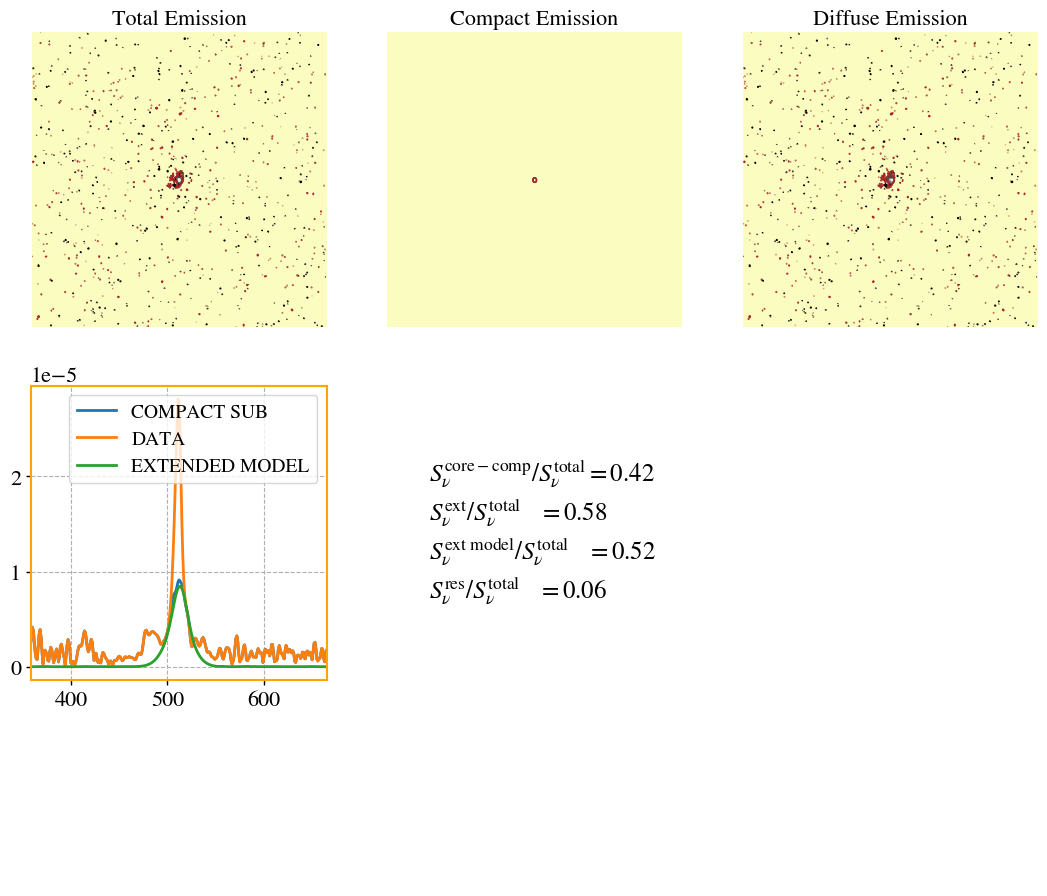

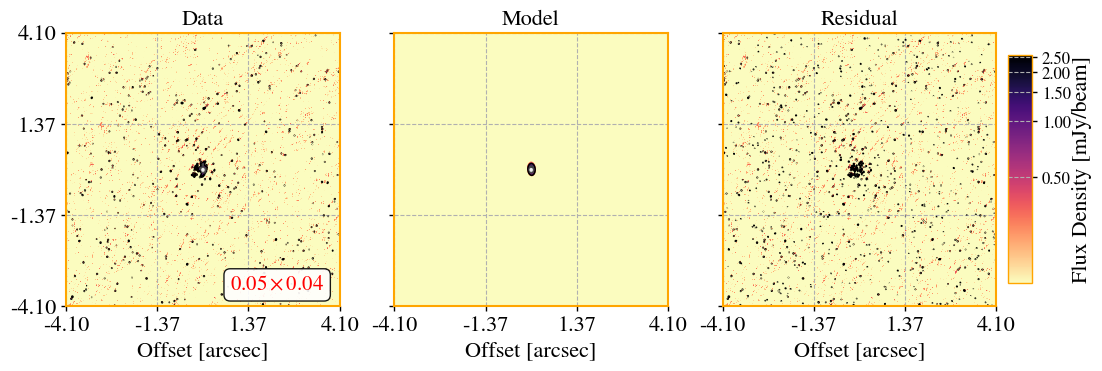

/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


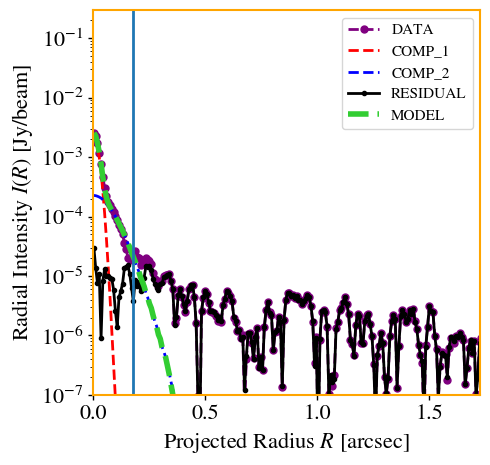

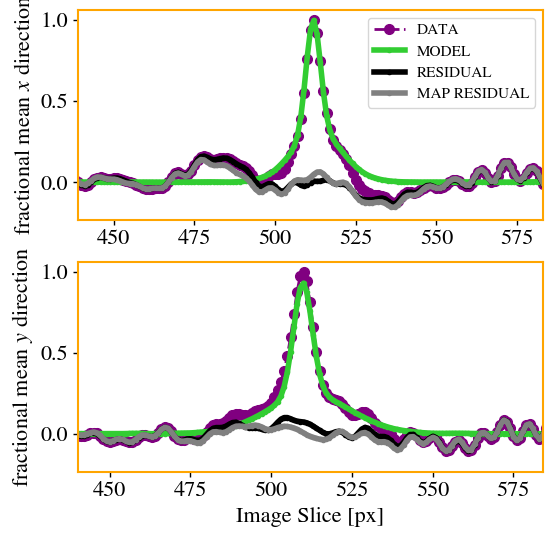

Using rms provided...
128 512 384


/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


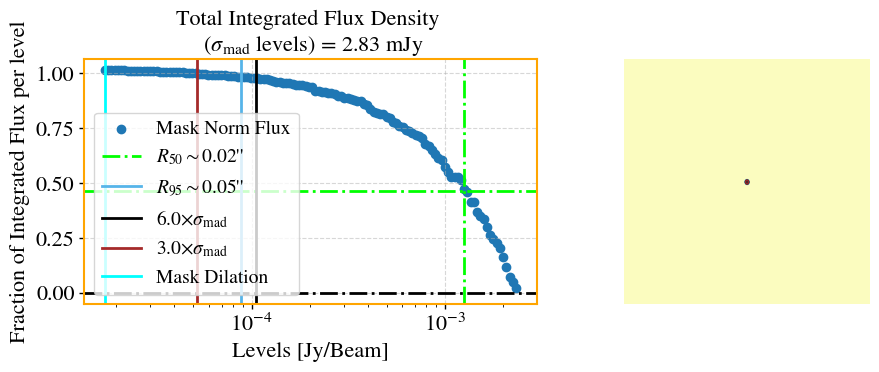

/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


Using rms provided...
128 512 384
non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse


/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


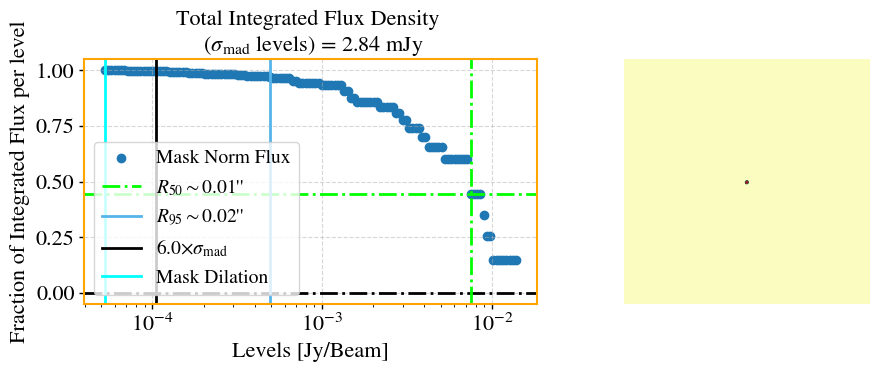

/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


Using rms provided...
128 512 384


/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


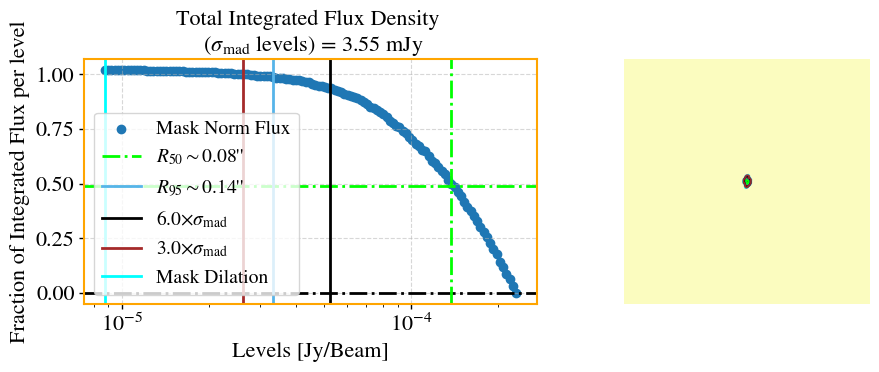

/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


Using rms provided...
128 512 384


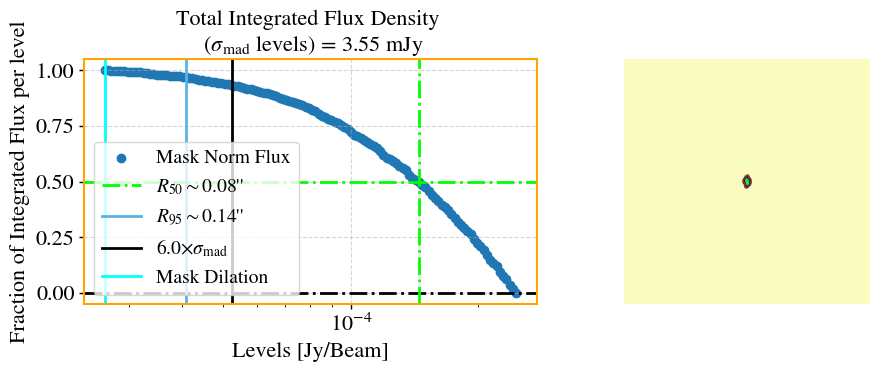

/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
2023-10-11 03:43:22 - INFO - +--------------------------------+
2023-10-11 03:43:22 - INFO - | Core-Compact Component Sizes |
2023-10-11 03:43:22 - INFO - +--------------------------------+
2023-10-11 03:43:22 - INFO -  >=> Beam Size = 5.00 px
2023-10-11 03:43:22 - INFO -  >=> Beam Size = 32.82  pc
2023-10-11 03:43:22 - INFO -  >=> Rn Main Compact = 8.93  pc
2023-10-11 03:43:22 - INFO -  >=> C50 Compact Deconv Radii = 7.41  pc
2023-10-11 03:43:22 - INFO -  >=> C50 Compact Conv Radii = 18.52  pc
2023-10-11 03:43:22 - INFO -  >=> C95 Compact Deconv Radii = 17.76  pc
2023-10-11 03:43:22 - INFO -  >=> C95 Compact Conv Radii = 42.39  pc
2023-10-11 03:43:22 - INFO - +----------------------------+
2023-10-11 03:43:22 - INFO - | Extended Component Sizes |
2023-10-11 03:43:22 - INFO - +-----------------

In [84]:
smfr = mp.sersic_multifit_radio(input_data,
                                SE, #source extraction object, from previous step
                                which_residual = 'shuffled', #natural or shuffled (natural is experimental!)
                                fix_geometry=True, #for stability purposes, keep True for now. 
                                comp_ids=['1'],# which component label is compact?
                                dr_fix=[5,50,5,100,100,100],#for each component, radial element size to fix (x0,y0) positions
                                fix_value_n=[0.5,0.5,0.5,0.5,0.5,0.5,0.5],#for each component, the Sersic index value to be fixed. 
                                fix_n=[True,True,True,True,True,True],#for each component, fix or not the Sersic index. 
                                aspect=None,#elliptical or circular gaussian for beam convolution? 
                                z = mlibs.z_d['VV705'])

### Analysing Results


All results are stored in the object `smfr`. 
Model images (convolved and deconvolved) are saved as `.fits` files having a copy of the header 
from the original image file data. Example of these files are: 
 - `*_dec_model.fits` >> Deconvolved total model image.
 - `*_model.fits` >> Convolved total model image.
 - `*_residual.fits` >> Residual model image. 
 - `*_dec_model_component_i.fits` >> Deconvolved model image for model component `i`. `i` vary from 1 to the total number of model components.
 - `*_model_component_i.fits` >> Convolved model image for model component `i`.
 - `*_compact.fits` >> Convolved image containing all compact structures.
 - `*_extended.fits` >> Convolved image containing the extended structures. This is obtained by `extended = data - compact`.
 - `*_fit.pickle` >> Contains a pickle object with all the `LMFIT` results.
 - `*_fit_modeldict.pickle` >> Contains a pickle object with all model components images (convolved and deconvolved). Note, this is a big file, and probably will be removed in a future version.
 - `*_model_mini_params.csv` >> contain the best-fit minimised parameters and (when possible) standard errors.
 - `*_mini_corr.csv` >> When successful, this contains the correlation matrix for the model parameters. 


First, we can inspect the model images, residual and diffuse emission.

## The structure of the diffuse emission
Lets visualise the model images of our fitting. 

  >> Center -->  [512 510   0   0]


Text(0.5, 1.0, 'Data')

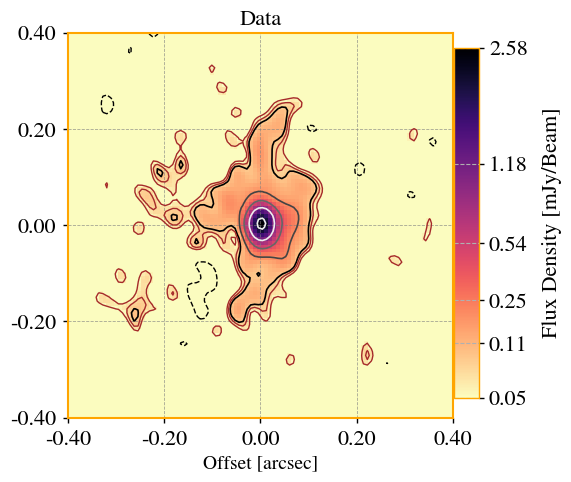

In [92]:
# center = nd.maximum_position(input_data.image_data_2D)
center = (int(smfr.results_fit['f1_x0'][0]),int(smfr.results_fit['f1_y0'][0]))
rms = input_data.rms_res
ax = mlibs.eimshow(input_data.filename,
             crop=True,box_size=50,vmax_factor=1.0,
             vmax=input_data.image_data_2D.max(),rms=rms)
ax.set_title('Data')

Input image is not a fits file.
Input image is not a fits file.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Diffuse Emission')

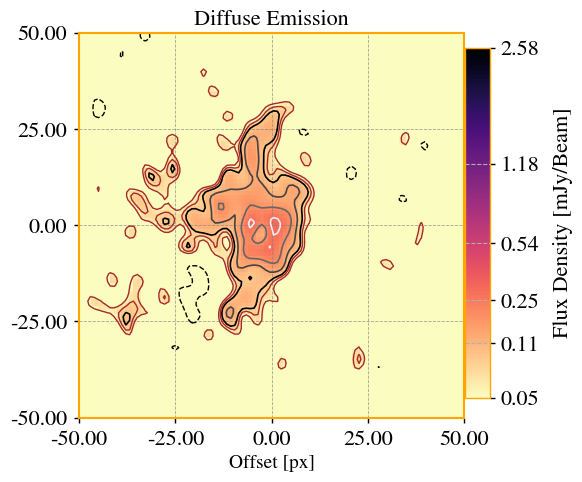

In [93]:
ax = mlibs.eimshow(input_data.image_data_2D- smfr.models[0]['model_c1_conv'],
        crop=True,box_size=50,vmax_factor=1.0,
        rms=rms,vmax=input_data.image_data_2D.max())
ax.set_title('Diffuse Emission')

Input image is not a fits file.
Input image is not a fits file.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Compact Deconvolved')

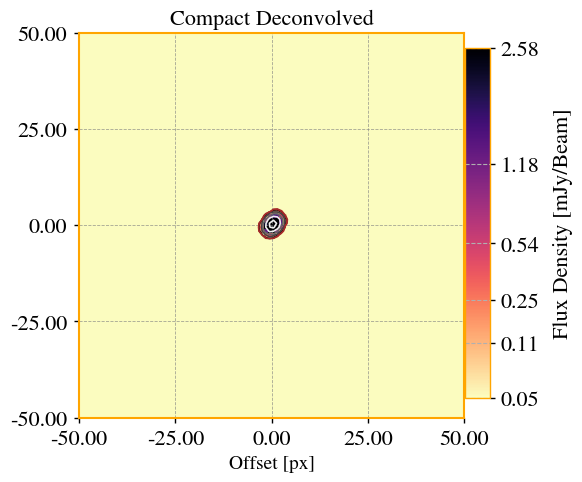

In [94]:
ax=mlibs.eimshow(smfr.models[0]['model_c1'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Deconvolved')

Input image is not a fits file.
Input image is not a fits file.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Compact Convolved')

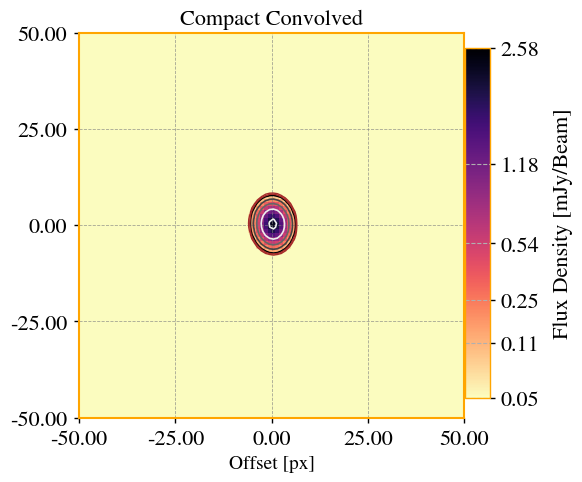

In [95]:
ax=mlibs.eimshow(smfr.models[0]['model_c1_conv'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Convolved')

Input image is not a fits file.
Input image is not a fits file.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Model Deconvolved')

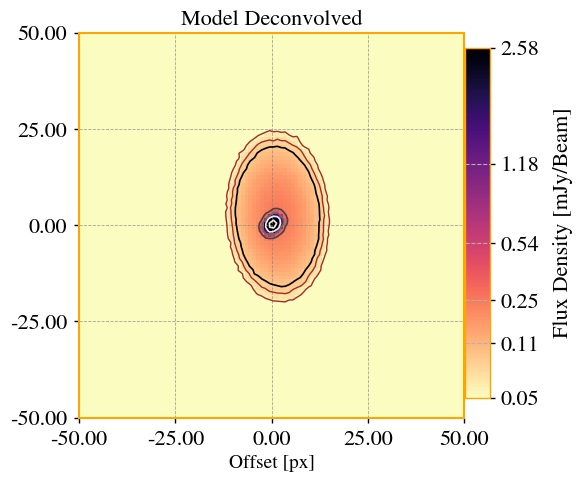

In [96]:
ax=mlibs.eimshow(smfr.models[0]['model_total'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Deconvolved')

Input image is not a fits file.
Input image is not a fits file.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Model Convolved')

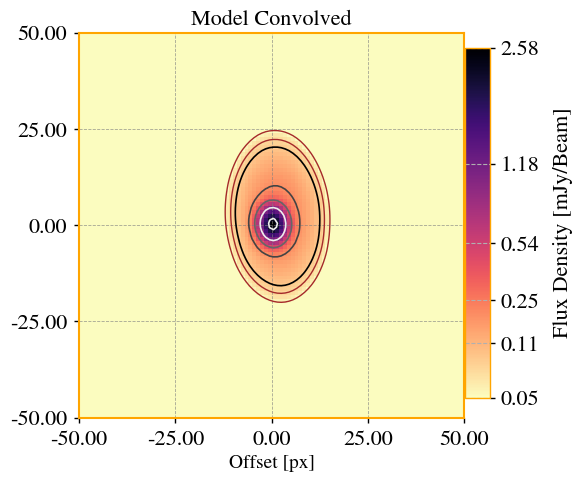

In [97]:
ax=mlibs.eimshow(smfr.models[0]['model_total_conv'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Convolved')

No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Residual')

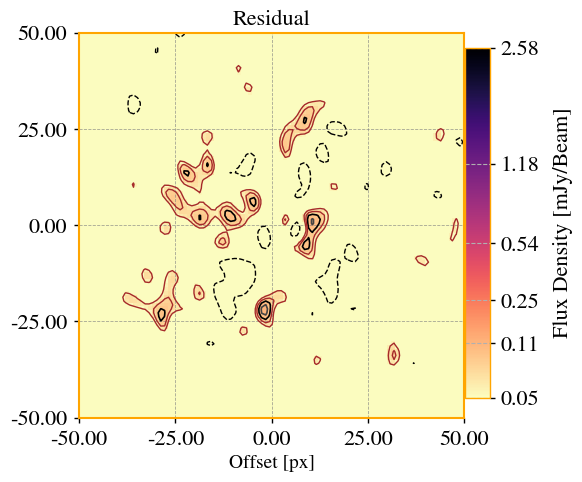

In [98]:
ax = mlibs.eimshow(input_data.image_data_2D- smfr.models[0]['model_total_conv'],
             center=center,
             crop=True,box_size=50,vmax_factor=1.0,vmin_factor=3,
             rms=rms,
             vmax=input_data.image_data_2D.max()
            )
ax.set_title('Residual')

In [99]:
print(f"Total flux in model = {smfr.results_fit['flux_density_model'][0]:.2f} mJy")
print(f"Total flux in data = {smfr.results_fit['flux_data'][0]:.2f} mJy")
print(f"Total flux in res = {smfr.results_fit['flux_res'][0]:.2f} mJy")


Total flux in model = 6.39 mJy
Total flux in data = 6.84 mJy
Total flux in res = 0.44 mJy


#### Analysing fit statistics (model parameters)

In [100]:
smfr.lmfit_results[0]

name,value,standard error,relative error,initial value,min,max,vary
f1_x0,510.595738,0.00625706,(0.00%),510.59573761958563,505.952729,515.952729,True
f1_y0,508.539196,0.00769201,(0.00%),508.53919608056606,507.136417,517.136417,True
f1_PA,-129.722384,2.62758238,(2.03%),-129.72238354110783,-172.723478,7.27652238,True
f1_ell,0.23836645,0.01759896,(7.38%),0.23836644659627837,0.05897790,0.58977897,True
f1_n,0.51000000,0.33812910,(66.30%),0.5099999999998157,0.49000000,0.51000000,True
f1_In,0.00716449,0.00430029,(60.02%),0.007164489992252448,1.7762e-05,0.01776194,True
f1_Rn,1.36116168,0.69749954,(51.24%),1.361161676762014,0.08712142,17.4242849,True
f1_cg,-0.00999858,1.16903194,(11691.98%),-0.00999858316544365,-0.01000000,0.01000000,True
f2_x0,511.815287,0.05117922,(0.01%),511.8152867706867,460.952729,560.952729,True
f2_y0,510.534423,0.08395956,(0.02%),510.5344231918837,462.136417,562.136417,True


### Check decomposition results: Compact vs Extended
Now, we can investigate the integrated fluxes between core-compact structures in relation to diffuse ones. 

Note that we consider that the diffuse flux density is the sum between the flux density from the extended model component and the flux density of the residual map.

In [101]:
print(f"Total flux in compact = {smfr.results_fit['flux_density_compact'][0]:.2f} mJy")
print(f"Total flux in extended = {smfr.results_fit['flux_density_extended_model'][0] + smfr.results_fit['flux_res'][0]:.2f} mJy")

# The total flux density in the diffuse regions are saved in:
print(f"Total flux in extended = {smfr.results_fit['flux_density_ext2'][0]:.2f} mJy")


Total flux in compact = 2.85 mJy
Total flux in extended = 3.99 mJy
Total flux in extended = 3.99 mJy


### Physical Sizes of the components
For completeness, we calculate convolved and deconvolved physical properties. 
The properties of the deconvolved model images, referent to compact structures, are stored inside `smfr.results_compact_deconv_morpho`, while properties of convolved model images for compact structures in `smfr.results_compact_conv_morpho`. 

Similarly, we have for the extended structures: `smfr.results_ext_deconv_morpho` and `smfr.results_ext_conv_morpho`. 

Each one of these measurements stores the same quantities that were calculated with `radio_image_analysis` previously, for the full radio emission, but now for individual model components. 

In [102]:
# list(smfr.results_compact_conv_morpho.keys())

In [103]:
# Lets calculate the pixel size in physical units (pc).
print(f"Redshift of VV705 = {mlibs.z_d['VV705']}")
pix_to_pc = mlibs.pixsize_to_pc(z=mlibs.z_d['VV705'],
                          cell_size=mlibs.get_cell_size(input_data.filename))
print(f"1 px = {pix_to_pc:.2f} pc")

Redshift of VV705 = 0.04019
1 px = 6.56 pc


#### Compact Components
First, let's analyse the results for our compact model(s)/structure(s).

In [104]:
# The effective radius in terms of the Sersic Rn parameter.
# This is a deconvolved quantity.
print(f"Rn ={smfr.results_fit['f1_Rn'][0] * pix_to_pc : .0f} pc")

Rn = 9 pc


In [105]:
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R50 ={smfr.results_compact_deconv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Deconv R50 = 7 pc


In [106]:
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R50 ={smfr.results_compact_conv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Conv R50 = 19 pc


##### Total sizes

In [107]:
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R95 ={smfr.results_compact_deconv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Deconv R95 = 18 pc


In [108]:
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R95 ={smfr.results_compact_conv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Conv R95 = 42 pc


#### Extended Components
Now, we move to our diffuse model(s)/structure(s).

In [109]:
print(f"Rn ={smfr.results_fit['f2_Rn'][0] * pix_to_pc : .0f} pc")

Rn = 94 pc


In [110]:
print(f"Deconv R50 ={smfr.results_ext_deconv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Deconv R50 = 65 pc


In [111]:
print(f"Conv R50 ={smfr.results_ext_conv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Conv R50 = 66 pc


#### Total Sizes

In [112]:
print(f"Deconv R95 ={smfr.results_ext_deconv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Deconv R95 = 113 pc


In [113]:
print(f"Conv R95 ={smfr.results_ext_conv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Conv R95 = 117 pc


### Compute SFR Estimates for Diffuse Structures and the Brightness Temperature
For star formation rates, some assumptions are made, as discussed in the paper. 

Here, we take just an approximation, since we are using only one frequency. 
But we are interested in the amount of energy that is coming from diffuse structures, and try to translate that to SFR.

We use the fitting results to compute the SFR. Within `smfr`, information is stored regarding the total flux density in the extended structures (`'flux_density_ext2'`) and the sizes.

The class `radio_star_formation` from `morphen` deals with the calculations, provided the object `smfr`. Note also that you need to provide the redshift of the galaxy. 

In [114]:
SFR = mp.radio_star_formation(input_data,smfr,z=mlibs.z_d['VV705'])

2023-10-11 03:56:30 - INFO - Using frequency of 5.18 GHz for star formation estimate.
2023-10-11 03:56:30 - INFO - +-----------------+
2023-10-11 03:56:30 - INFO - | SFR Estimates |
2023-10-11 03:56:30 - INFO - +-----------------+
2023-10-11 03:56:30 - INFO -  ==> SFR =25.36 +/- 3.17 Mo/yr
2023-10-11 03:56:30 - INFO - +------------------+
2023-10-11 03:56:30 - INFO - | sSFR Estimates |
2023-10-11 03:56:30 - INFO - +------------------+
2023-10-11 03:56:30 - INFO -  >=> Deconvolved A50 sSFR = 1917.44 Mo/(yr kpc^2)
2023-10-11 03:56:30 - INFO -  >=> Convolved A50 sSFR = 1868.75 Mo/(yr kpc^2)
2023-10-11 03:56:30 - INFO -  >=> Deconvolved A95 sSFR = 628.23 Mo/(yr kpc^2)
2023-10-11 03:56:30 - INFO -  >=> Convolved A95 sSFR = 587.48 Mo/(yr kpc^2)
2023-10-11 03:56:30 - INFO - +--------------------------+
2023-10-11 03:56:30 - INFO - | Brightness Temperature |
2023-10-11 03:56:30 - INFO - +--------------------------+
2023-10-11 03:56:30 - INFO -  ==> TB Rn Fit = 5.47 e5 K
2023-10-11 03:56:30 - I

In [115]:
mp.radio_star_formation??

Init signature:
mp.radio_star_formation(
    input_data,
    SMFR,
    decompose=True,
    z=0.01,
    calibration_kind='Murphy12',
    alpha=-0.85,
    alpha_NT=-0.85,
    frequency=None,
)
Source:        
class radio_star_formation():
    """
    Compute star-formation estimates from radio emission, given the converstion
    law.
    """

    def __init__(self, input_data, SMFR,decompose = True,z=0.01,
                 calibration_kind='Murphy12',
                 alpha = -0.85, alpha_NT = -0.85, frequency = None):
        self.input_data = input_data
        self.SMFR = SMFR
        self.decompose = decompose
        self.z = z
        self.frequency = frequency #in GHz
        self.alpha = alpha
        self.alpha_NT = alpha_NT
        self.return_with_error = True
        self.cell_size = mlibs.get_cell_size(self.input_data.filename)
        self.pix_to_pc = mlibs.pixsize_to_pc(z=self.z,
                                  cell_size=self.cell_size)


        if frequency is None:
  

In [116]:
SFR = mp.radio_star_formation(input_data,smfr,z=mlibs.z_d['VV705'],calibration_kind='Murphy12',frequency=6)

2023-10-11 03:56:33 - INFO - +-----------------+
2023-10-11 03:56:33 - INFO - | SFR Estimates |
2023-10-11 03:56:33 - INFO - +-----------------+
2023-10-11 03:56:33 - INFO -  ==> SFR =27.66 +/- 3.45 Mo/yr
2023-10-11 03:56:33 - INFO - +------------------+
2023-10-11 03:56:33 - INFO - | sSFR Estimates |
2023-10-11 03:56:33 - INFO - +------------------+
2023-10-11 03:56:33 - INFO -  >=> Deconvolved A50 sSFR = 2090.65 Mo/(yr kpc^2)
2023-10-11 03:56:33 - INFO -  >=> Convolved A50 sSFR = 2037.56 Mo/(yr kpc^2)
2023-10-11 03:56:33 - INFO -  >=> Deconvolved A95 sSFR = 684.98 Mo/(yr kpc^2)
2023-10-11 03:56:33 - INFO -  >=> Convolved A95 sSFR = 640.55 Mo/(yr kpc^2)
2023-10-11 03:56:33 - INFO - +--------------------------+
2023-10-11 03:56:33 - INFO - | Brightness Temperature |
2023-10-11 03:56:33 - INFO - +--------------------------+
2023-10-11 03:56:33 - INFO -  ==> TB Rn Fit = 4.09 e5 K
2023-10-11 03:56:33 - INFO -  ==> TB R50 Fit = 15.40 e5 K


In [117]:
# smfr = mp.sersic_multifit_radio(input_data,
#                                 SE, #source extraction object, from previous step
#                                 which_residual = 'shuffled', #natural or shuffled (natural is experimental!)
#                                 fix_geometry=True, #for stability purposes, keep True for now. 
#                                 comp_ids=['1'],# which component label is compact?
#                                 dr_fix=[5,50,5,100,100,100],#for each component, radial element size to fix (x0,y0) positions
#                                 fix_value_n=[0.5,0.5,0.5,0.5,0.5,0.5,0.5],#for each component, the Sersic index value to be fixed. 
#                                 fix_n=[True,True,True,True,True,True],#for each component, fix or not the Sersic index. 
#                                 aspect=None,#elliptical or circular gaussian for beam convolution? 
#                                 z = mlibs.z_d['VV705'])

## Example 2: Multi-Sersic Fit with 5 model components.

In [19]:
# lets select another image from our list of images. 
idx = -2
input_data=mp.read_data(filename=imagelist_vla[idx],
                        residualname=residuallist_vla[idx])

Image File: clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
Residual File: clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-residual.cutout_north.fits


In [20]:
image_data = input_data.image_data_2D
residual_data = input_data.residual_data_2D

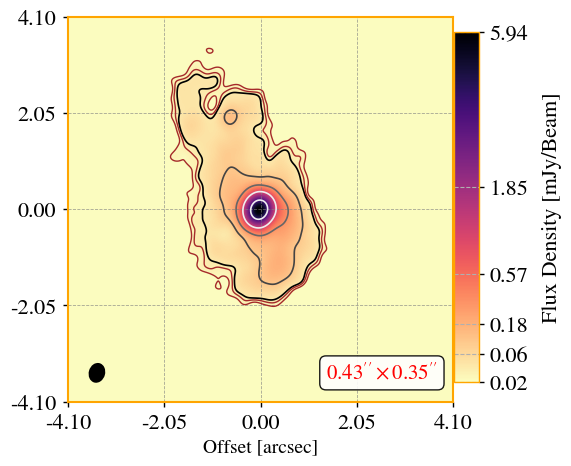

In [21]:
ax=mlibs.eimshow(input_data.filename,add_beam=True,crop=False,box_size=50,
        vmin_factor=3.0,vmax_factor=0.99, #level factor (max from peak, and min from std)
        neg_levels=np.asarray([-3]), # negative contours to draw -- which negative std level?
        CM='magma_r',
       )

Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


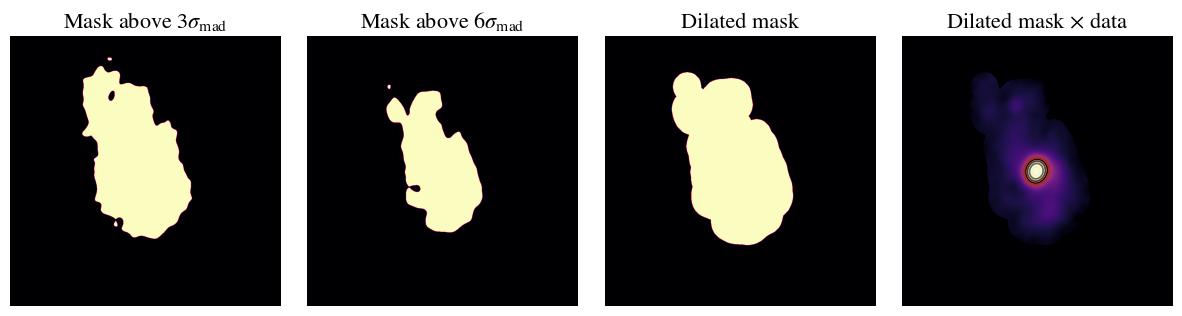

In [22]:
rms = input_data.rms_res
_, mask = mlibs.mask_dilation(mlibs.ctn(imagelist_vla[-1]), PLOT=False,dilation_type='disk',
                        sigma=6, iterations=2, dilation_size=None)
_, mask_self = mlibs.mask_dilation(input_data.filename, PLOT=True,dilation_type='disk',
                        sigma=6, iterations=2, dilation_size=None)


In [23]:
bwf, bhf = 2, 2 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 10, 10 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.1
deblend_cont = 1e-6
deblend_nthresh = 5
sigma = 4
# ell_size_factor = 2.5
ell_size_factor = 1.0*get_ell_size_factor(psf_current = mlibs.get_beam_size_px(input_data.filename)[0])

48.19383800980803


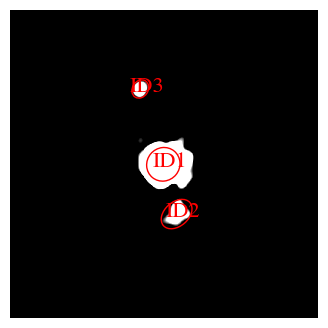

In [24]:

SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=1.0,
                          apply_mask=False,sigma_mask=6,
                          show_petro_plots=True,
                          dry_run=True)
# plt.imshow(input_data.image_data_2D)

Looking to the radio emission of this source, we see that structure `ID1` (the compact part) is surrounded by diffuse emission, which includes another structure `ID2`. We also see that `ID3` is almost isolated, so in principle one model component is enough. 

Lets assume that we require one extra component to model the main structure, `ID1`. If we do `ids_to_add=[1]`, we will have `ID1 -> (COMP_1, COMP_4)`,  where `COMP_4` is the newly added component. We also have `ID2 -> COMP_2` and `ID3 -> COMP_3`. 

Between these components, we are going to assume that `COMP_1` and `COMP_3` are compact components, while `COMP_2` and `COMP_4` represents diffuse structures. 

Also, we are giving a larger bound for the coordinates of our added component, `COMP_4`. 

48.19383800980803


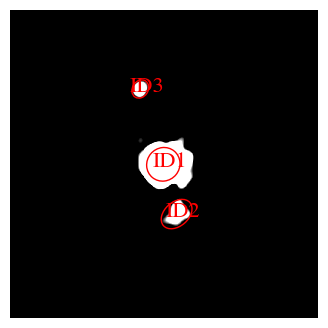

/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


/home/sagauga/pCloudDrive/PhD/GitHub/morphen/libs/libs.py:2009: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-10-11 04:04:27	WARN	componentlist::close	componentlist closed


# of components to be fitted = 3
# of model components to be fitted = 4


In [25]:
SE = mp.source_extraction(input_data, ids_to_add=[1],
                          ell_size_factor = ell_size_factor, sigma=sigma,
                          bwf=bwf, bhf=bhf, fwf=fwf, fhf=fhf,
                          clean_param=clean_param, 
                          deblend_cont=deblend_cont, 
                          deblend_nthresh=deblend_nthresh,
                          apply_mask=False,sigma_mask=6,
                          show_petro_plots=False,#for now, hide petro plots. 
                          dry_run=False)

In [26]:
for i in range(1,SE.sources_photometries['ncomps']+1):
    print('R50 of comp', i, SE.sources_photometries['c'+str(i)+'_R50'])

R50 of comp 1 28.890578115623125
R50 of comp 2 42.75887249152307
R50 of comp 3 20.80896179235847
R50 of comp 4 86.67173434686937


#######################
['2', '4'] ['1' '2' '3' '4']
Fitting clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
rms res =  0.6059130203041458
rms data =  5.768045406703081 ; rms res =  3.494933813626919 ; ratio =  0.6059130203041458
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


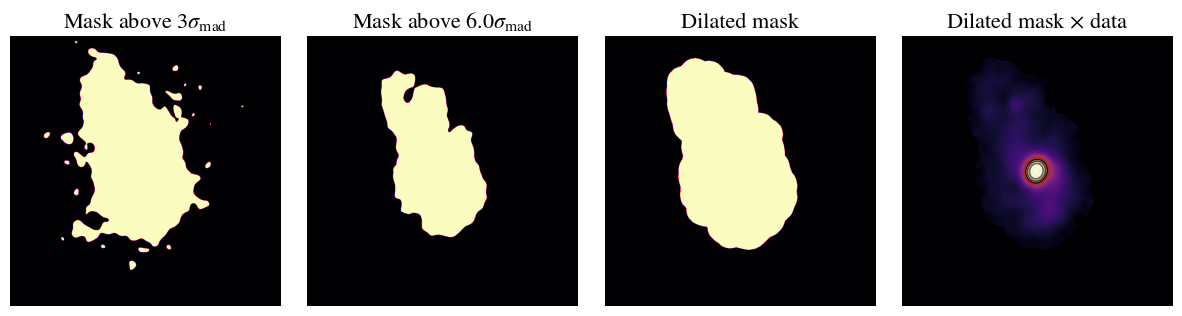

PSF BEAM SIZE is >=>  48
PSF SIZE is >=>  1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-10-11 04:04:33	WARN	componentlist::close	componentlist closed
2023-10-11 05:04:33.040532: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:458] TfrtCpuClient created.
2023-10-11 05:04:33.158701: I external/xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:910] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-11 05:04:33.159004: I external/xla/xla/service/service.cc:168] XLA service 0x55f9ecddf350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 05:04:33.159033: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-10-11 05:04:33.159381: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:627] Using BFC allocator.
2023-10-11 05:04:33.159415: I external/xla/xla/pjrt/gpu/gp

Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 2  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 3  to 0.5.
{'f1_x0': {'value': 508.5116563595037, 'min': 503.5116563595037, 'max': 513.5116563595037}, 'f1_y0': {'value': 510.3690416656423, 'min': 505.3690416656423, 'max': 515.3690416656423}, 'f1_PA': {'value': 66.30965753828728, 'min': -23.690342461712717, 'max': 156.3096575382873}, 'f1_ell': {'value': 0.0786713152909787, 'min': 0.01573426305819574, 'max': 0.5}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.0029203074989796038, 'min': 0.0002920307498979604, 'max': 0.29203074989796035}, 'f1_Rn': {'value': 28.890578115623125, 'min': 0.2889057811562313, 'max': 57.78115623124625}, 'f1_cg': {'value': 0.0, 'min': -0.01, 'max': 0.01}, 'f2_x0': {'value': 554.2474704762539, 'min': 549.2474704762539, 'ma

In [ ]:
dr_fix=[5,#model component 1
        5,#model component 2
        5,#model component 3
        100,#model component 4
       ]

fix_n = [True,#model component 1
         True,#model component 2
         True,#model component 3
         True,#model component 4
        ]

fix_value_n = [0.5,#model component 1
               0.5,#model component 2
               0.5,#model component 3
               0.5,#model component 4
               ]

smfr = mp.sersic_multifit_radio(input_data,
                                SE, #source extraction object, from previous step
                                which_residual = 'shuffled', #natural or shuffled (natural is experimental!)
                                fix_geometry=True, #for stability purposes, keep True for now. 
                                comp_ids=['1','3'],# which model component label represents compact structures?
                                dr_fix=dr_fix,#for each component, radial element size to fix (x0,y0) positions
                                fix_value_n=fix_value_n,#for each component, the Sersic index value to be fixed. 
                                fix_n=fix_n,#for each component, fix or not the Sersic index. 
                                aspect=None,#elliptical or circular gaussian for beam convolution? 
                                z = mlibs.z_d['VV705'])

## Total model is not good?
Lets analyse the fit result again:
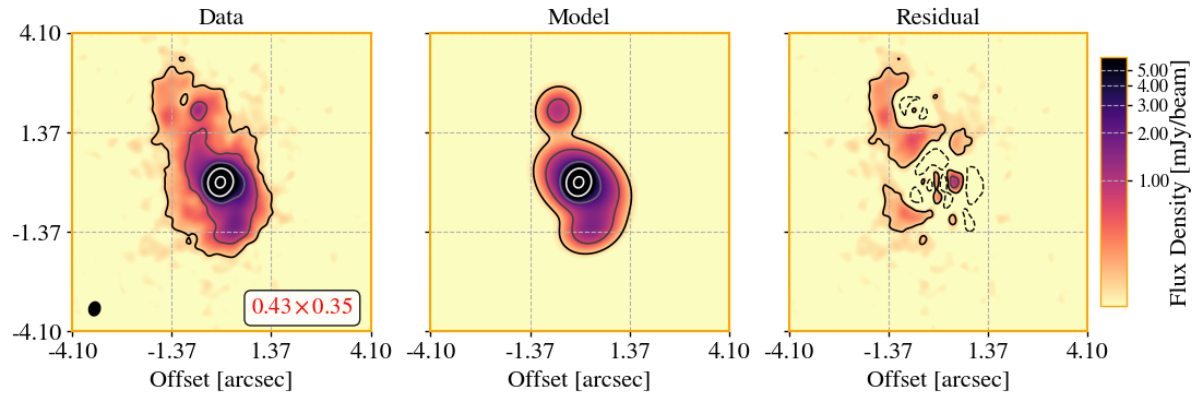

We see that we still have significant residuals, specially on larger scales. This is expected since the radio emission is complex. 
What we can do to improve our model, is to, instead of adding a single model component to `ID1`, we add two extra components, so `ID1 -> (COMP_1, COMP_4, COMP_5)`: `ids_to_add = [1,4]`. 
Note that `ids_to_add` is incremental, so we are adding 1 extra component to `ID1`, which results in `COMP_4` (where `COMP_1` being the parent component), and then we add another model component to `COMP_4`, resulting in `COMP_5`. 

In [ ]:
SE = mp.source_extraction(input_data, ids_to_add=[1,4],
                          ell_size_factor = ell_size_factor, sigma=sigma,
                          bwf=bwf, bhf=bhf, fwf=fwf, fhf=fhf,
                          clean_param=clean_param, 
                          deblend_cont=deblend_cont, 
                          deblend_nthresh=deblend_nthresh,
                          apply_mask=False,sigma_mask=6,
                          show_petro_plots=False,#for now, hide petro plots. 
                          dry_run=False)

In [ ]:
for i in range(1,SE.sources_photometries['ncomps']+1):
    print('R50 of comp', i, SE.sources_photometries['c'+str(i)+'_R50'])

In [ ]:
dr_fix=[5,#model component 1
        5,#model component 2
        5,#model component 3
        100,#model component 4
        100,#model component 5
       ]

fix_n = [True,#model component 1
         True,#model component 2
         True,#model component 3
         True,#model component 4
         True,#model component 5
        ]

fix_value_n = [0.5,#model component 1
               0.5,#model component 2
               0.5,#model component 3
               0.5,#model component 4
               0.5,#model component 5
               ]

smfr = mp.sersic_multifit_radio(input_data,
                                SE, #source extraction object, from previous step
                                which_residual = 'natural', #natural or shuffled (natural is experimental!)
                                fix_geometry=True, #for stability purposes, keep True for now. 
                                comp_ids=['1','3'],# which model component label represents compact structures?
                                dr_fix=dr_fix,#for each component, radial element size to fix (x0,y0) positions
                                fix_value_n=fix_value_n,#for each component, the Sersic index value to be fixed. 
                                fix_n=fix_n,#for each component, fix or not the Sersic index. 
                                aspect=None,#elliptical or circular gaussian for beam convolution? 
                                z = mlibs.z_d['VV705'])

In [ ]:
center = mlibs.nd.maximum_position(input_data.image_data_2D)
# center = (int(smfr.results_fit['f1_y0'][0]),int(smfr.results_fit['f1_x0'][0]))
rms = input_data.rms_res
ax = mlibs.eimshow(input_data.filename,center=center,
             crop=False,box_size=50,vmax_factor=1.0,
             vmax=input_data.image_data_2D.max(),rms=rms)
ax.set_title('Data')

In [ ]:
ax = mlibs.eimshow(input_data.image_data_2D- smfr.models[0]['model_c1_conv'],
        crop=False,box_size=50,vmax_factor=1.0,center=center,
        rms=rms,vmax=input_data.image_data_2D.max())
ax.set_title('Diffuse Emission')

In [ ]:
ax=mlibs.eimshow(smfr.models[0]['model_c1'],
           crop=False,box_size=50,rms=rms,center=center,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Deconvolved')

In [ ]:
ax=mlibs.eimshow(smfr.models[0]['model_c1_conv'],
           crop=False,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Convolved')

In [ ]:
ax=mlibs.eimshow(smfr.models[0]['model_total'],
           crop=False,box_size=50,rms=rms,center=center,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Deconvolved')

In [ ]:
ax=mlibs.eimshow(smfr.models[0]['model_total_conv'],
           crop=False,box_size=50,rms=rms,center=center,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Convolved')

In [ ]:
ax = mlibs.eimshow(input_data.image_data_2D- smfr.models[0]['model_total_conv'],
             center=center,
             crop=False,box_size=50,vmax_factor=1.0,vmin_factor=3,
             rms=rms,
             vmax=input_data.image_data_2D.max()
            )
ax.set_title('Residual')